# Word 2 Vec

In [1]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [2]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\Users\aswat\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aswat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aswat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
book_filenames = sorted(glob.glob("data/*.txt"))

In [7]:
book_filenames

['data\\A-Game-of-Thrones.txt']

In [8]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data\A-Game-of-Thrones.txt'...
Corpus is now 1581252 characters long



# Corpus to sentence

In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [11]:

#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [12]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [13]:
raw_sentences[5]

'“Dead is dead,” he said.'

In [14]:
sentence_to_wordlist(raw_sentences[5])

['Dead', 'is', 'dead', 'he', 'said']

In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 297,553 tokens


# Word 2 Vec

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:

thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
thrones2vec.build_vocab(sentences)

2017-10-21 14:48:09,905 : INFO : collecting all words and their counts
2017-10-21 14:48:09,907 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-10-21 14:48:09,959 : INFO : PROGRESS: at sentence #10000, processed 147662 words, keeping 9298 word types
2017-10-21 14:48:09,989 : INFO : collected 12578 word types from a corpus of 297553 raw words and 19930 sentences
2017-10-21 14:48:09,991 : INFO : Loading a fresh vocabulary
2017-10-21 14:48:10,012 : INFO : min_count=3 retains 6291 unique words (50% of original 12578, drops 6287)
2017-10-21 14:48:10,014 : INFO : min_count=3 leaves 289477 word corpus (97% of original 297553, drops 8076)
2017-10-21 14:48:10,049 : INFO : deleting the raw counts dictionary of 12578 items
2017-10-21 14:48:10,051 : INFO : sample=0.001 downsamples 50 most-common words
2017-10-21 14:48:10,053 : INFO : downsampling leaves estimated 221300 word corpus (76.4% of prior 289477)
2017-10-21 14:48:10,057 : INFO : estimated required memory for

In [20]:

print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 6291


In [24]:
thrones2vec.train(sentences, total_examples=token_count,epochs=1)

2017-10-21 15:02:54,789 : INFO : training model with 4 workers on 6291 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-10-21 15:02:55,724 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-10-21 15:02:55,728 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-10-21 15:02:55,784 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-10-21 15:02:55,791 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-10-21 15:02:55,793 : INFO : training on 297553 raw words (221135 effective words) took 1.0s, 223963 effective words/s
2017-10-21 15:02:55,794 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2017-10-21 15:02:55,796 : WARNING : supplied example count (19930) did not equal expected count (297553)


221135

In [25]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [27]:
all_word_vectors_matrix = thrones2vec.wv.syn0

In [28]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [30]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [31]:
points.head(10)

,word,x,y
0,by,-9.617074,-5.382259
1,missing,11.846902,1.912785
2,One,-2.628835,8.055566
3,A,6.272154,0.088089
4,of,-8.951296,-7.125036
5,Ice,3.570902,10.135238
6,and,-11.023402,1.821999
7,Fire,3.134533,-1.605151
8,We,2.161736,-10.625820
9,should,2.744721,-11.379984


In [32]:
sns.set_context("poster")

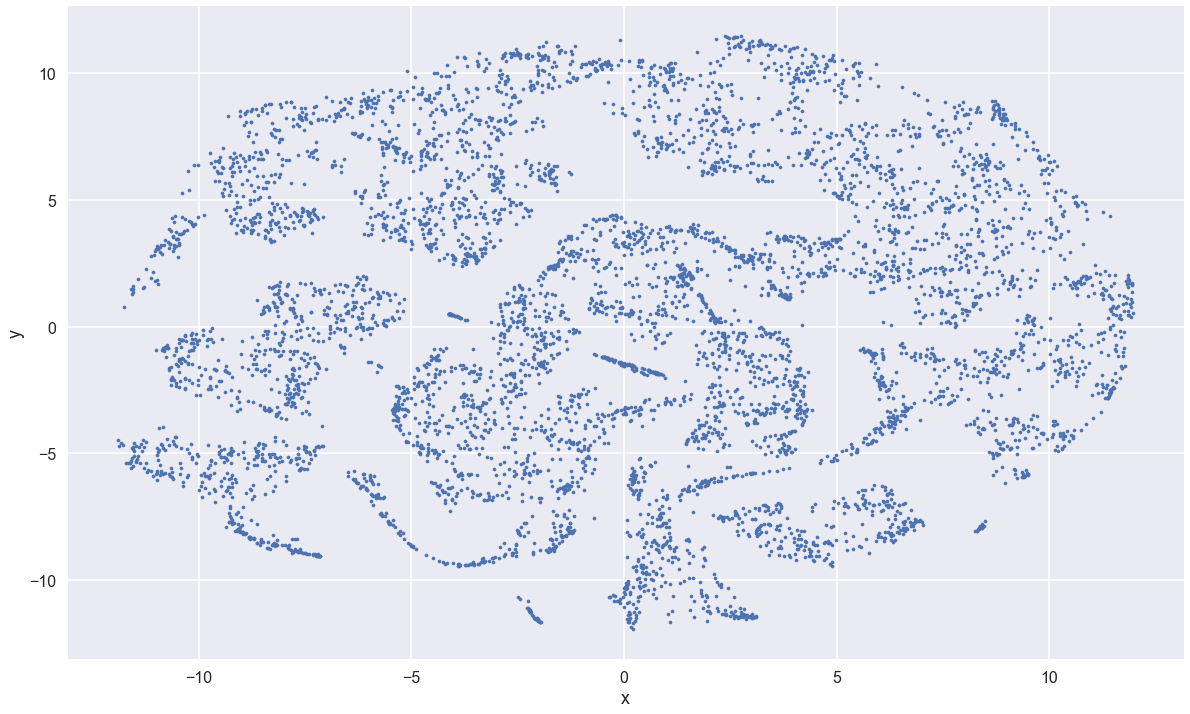

In [33]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [34]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

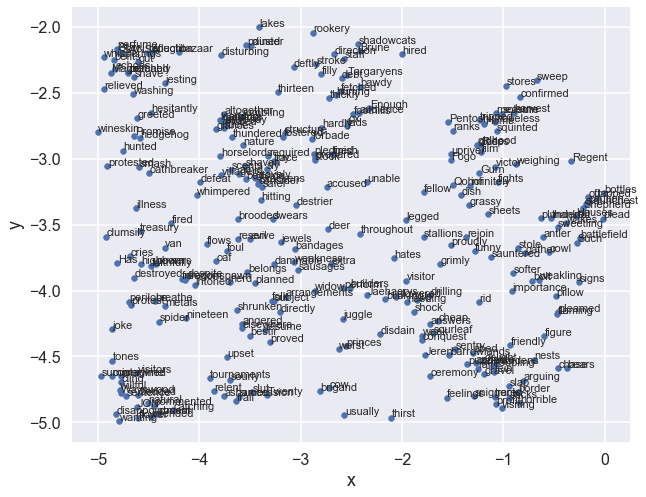

In [39]:
plot_region(x_bounds=(-5, 0), y_bounds=(-5, -2))

In [41]:
thrones2vec.most_similar("Stark")

[('Robert', 0.9911230206489563),
 ('peace', 0.9906680583953857),
 ('war', 0.9901843070983887),
 ('This', 0.9899907112121582),
 ('true', 0.9893050193786621),
 ('Eddard', 0.9892935752868652),
 ('life', 0.9879229068756104),
 ('No', 0.9875752925872803),
 ('has', 0.9866173267364502),
 ('death', 0.9864728450775146)]

In [42]:
thrones2vec.most_similar("Aerys")

[('Just', 0.9997806549072266),
 ('Joff', 0.9997702836990356),
 ('pretend', 0.9997075796127319),
 ('realize', 0.9996991157531738),
 ('proud', 0.9996941685676575),
 ('notion', 0.9996852874755859),
 ('pardon', 0.9996826648712158),
 ('oddly', 0.9996721744537354),
 ('grumbled', 0.9996604919433594),
 ('ofttimes', 0.9996497631072998)]

In [43]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [44]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")

Stark is related to Winterfell, as Frey is related to Riverrun


'Frey'

In [45]:
nearest_similarity_cosmul("Jaime", "sword", "wine")

Jaime is related to sword, as Tywin is related to wine


'Tywin'

In [46]:
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Arya is related to Nymeria, as far is related to dragons


'far'